#### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
data_path =  '/home/teachinglab/Documents/comm-project/data'
print(os.listdir(data_path))

['ab042_trial_data.csv', 'ab042_trial_starts.npy', 'ab042_cluster_spike_times.csv', 'ab042_spikes_dense.npy']


In [51]:
data_path =  '/home/teachinglab/Documents/comm-project/data'


# Load trial data
fname = 'ab042_trial_data.csv'
trial_df = pd.read_csv(os.path.join(data_path,fname))
trial_df.head()

trial_type_list = ['ah', 'wh','wm','fa','cr']
for trial_type in trial_type_list:
    print('Trial type, {}, #trials = {}'.format(trial_type, sum(trial_df[trial_type])))

Trial type, ah, #trials = 83
Trial type, wh, #trials = 42
Trial type, wm, #trials = 140
Trial type, fa, #trials = 36
Trial type, cr, #trials = 211


In [55]:
trial_colors = {'ah':'mediumblue',
               'wh':'forestgreen',
               'wm':'crimson',
               'fa':'k',
               'cr':'dimgray'}

#### Load neuron data

In [53]:
fname = 'ab042_cluster_spike_times.csv'
neuron_df = pd.read_csv(os.path.join(data_path,fname))
neuron_df.head()

,mouse_name,probe_id,cluster_id,n_spikes,fr,depth,sh,ch,amp,ks_label,group,curated,contam_pct,amplitude,spike_times,area
0,AB042,1,11,18844,3.355170,140,0,12,2.61722,good,good,1,0.0,80.7,[4.58315428e+00 4.82023206e+00 4.99889605e+00 ...,OFC
1,AB042,1,15,82884,14.757500,160,0,15,3.78658,good,good,1,0.0,117.2,[1.19608207e-01 1.19832537e+00 1.26132442e+00 ...,OFC
2,AB042,1,18,22369,3.982790,200,0,18,3.74118,good,good,1,0.2,155.9,[ 16.12826086 16.20829299 16.22845936 ......,OFC
3,AB042,1,25,103197,18.374200,260,0,25,2.54027,good,good,1,0.4,51.9,[9.13752968e-02 1.98307027e-01 3.14838613e-01 ...,OFC
4,AB042,1,27,5487,0.976959,260,0,25,2.98611,good,good,1,9.9,39.2,[3.04006209e+00 3.06686169e+00 3.21399281e+00 ...,OFC


In [45]:
areas = np.unique(neuron_df.area, return_counts=True)
print(areas)
area_list = areas[0]
print(area_list)

(array(['DLS', 'DS', 'Hippocampus', 'OFC', 'PPC', 'Thalamus', 'tjM1',
       'wM2', 'wS1'], dtype=object), array([ 32,  30,  25,  72, 100, 238, 166, 126,  58]))
['DLS' 'DS' 'Hippocampus' 'OFC' 'PPC' 'Thalamus' 'tjM1' 'wM2' 'wS1']


In [ ]:
area_colors = 

#### Load spike time data

In [54]:
fname = 'ab042_spikes_dense.npy'
spike_array = np.load(os.path.join(data_path,fname))
spike_array.shape

(847, 512, 401)

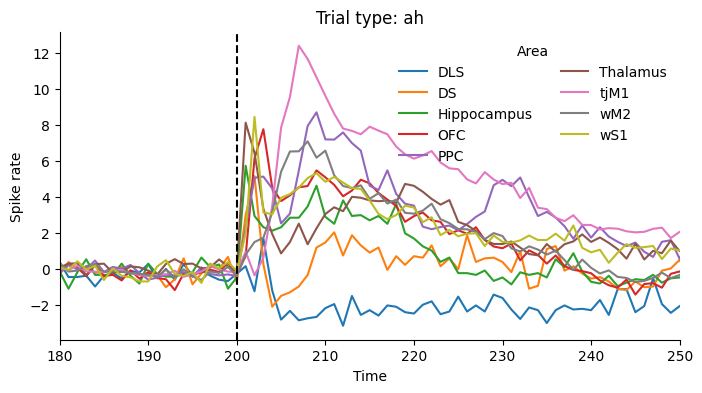

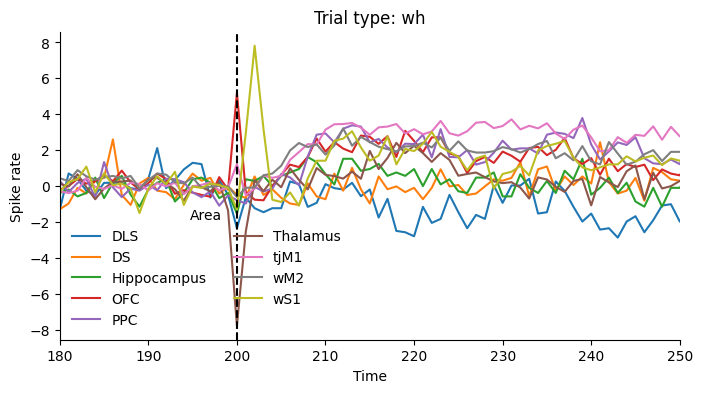

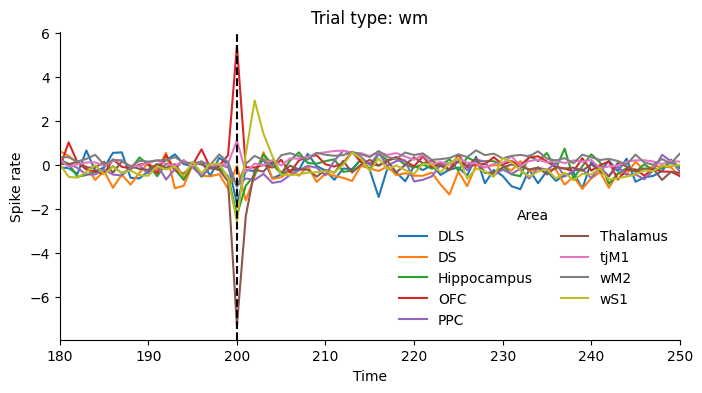

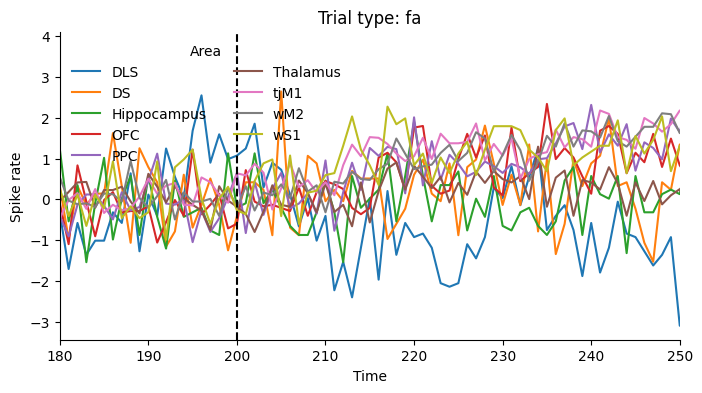

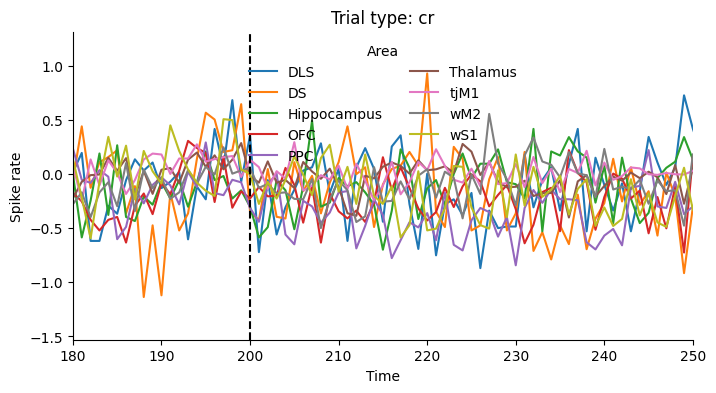

In [62]:
#### PSTHs

for trial_type in trial_type_list:

    trial_indices = trial_df[trial_df[trial_type]==1].index.values

    fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
    #for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        neuron_indices = neuron_df[neuron_df.area==area].index.values
        #print('Number of neurons:', len(neuron_indices))

        spike_array_sub = spike_array[neuron_indices][:,trial_indices,:]
        spike_array_sub_bas = spike_array_sub[:,:,0:100]
        bas = np.mean(spike_array_sub_bas)
        #print('Sub array dim', spike_array_sub.shape)

        ax.plot((np.mean(spike_array_sub, axis=(0,1)) - bas) /0.01, label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type))
    ax.axvline(x=200, ls='--',c='k')
    ax.set_xlim(180, 250)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)